In [1]:
%pylab inline
from numpywren.matrix import BigMatrix, BigSymmetricMatrix
from numpywren import matrix_utils, uops
from numpywren.matrix_init import shard_matrix
import pytest
import numpy as np
from numpy.linalg import cholesky
import pywren
import unittest
import concurrent.futures as fs
import time
import multiprocessing
import os
from importlib import reload
from numpywren import lambdapack as lp
from numpywren import binops
from collections import defaultdict
import seaborn as sns
import boto3
import numpywren
import numpywren.wait
from numpywren import job_runner
import pylab
import seaborn as sns
sns.set_style("whitegrid")

Populating the interactive namespace from numpy and matplotlib


In [2]:
env_dict = {}
env_dict["OMP_NUM_THREADS"] = str(1)
env_dict["AWS_ACCESS_KEY_ID"] = os.environ["AWS_ACCESS_KEY_ID"]
env_dict["AWS_SECRET_ACCESS_KEY"] = os.environ["AWS_SECRET_ACCESS_KEY"]

In [3]:
N = 65536 * 4


X = np.random.randn(N, 1)
print("Generating X")
shard_size = 4096 
shard_sizes = (shard_size, 1)
pwex = pywren.default_executor()
executor = pywren.default_executor


Generating X


In [4]:
X_sharded = BigMatrix("cholesky_test_{0}_{1}".format(N, shard_size), shape=X.shape, shard_sizes=shard_sizes, write_header=True)


In [5]:
shard_matrix(X_sharded, X)

In [6]:
%time XXT_sharded = binops.gemm(pwex, X_sharded, X_sharded.T, overwrite=False)

gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)
Out Shape (262144, 262144)
Total number of output blocks 2080
Total number of output blocks that exist 2080
Number of output blocks to generate  0
<function _gemm_remote_0 at 0x7f6e4c514a60>
CPU times: user 700 ms, sys: 16 ms, total: 716 ms
Wall time: 1.45 s


In [7]:
XXT_sharded.lambdav = 1
%time instructions_full,L_sharded,trailing= lp._chol(XXT_sharded)

CPU times: user 1.02 s, sys: 44 ms, total: 1.07 s
Wall time: 1.11 s


In [8]:
for i,inst_block in enumerate(instructions_full):
   for inst in inst_block.instrs:
       if (inst.i_code == lp.OC.CHOL):
           print(i)


0
2080
4096
6049
7940
9770
11540
13251
14904
16500
18040
19525
20956
22334
23660
24935
26160
27336
28464
29545
30580
31570
32516
33419
34280
35100
35880
36621
37324
37990
38620
39215
39776
40304
40800
41265
41700
42106
42484
42835
43160
43460
43736
43989
44220
44430
44620
44791
44944
45080
45200
45305
45396
45474
45540
45595
45640
45676
45704
45725
45740
45750
45756
45759


In [9]:
len(instructions_full)

45760

In [10]:
INSTRUCTION_TO_TRUNCATE = 5000
NUM_CORES = 100
NUM_MAX_CORES = 3000

In [11]:
instructions = instructions_full[:INSTRUCTION_TO_TRUNCATE]

In [12]:
pwex = pywren.default_executor()
config = pwex.config

In [13]:
program = lp.LambdaPackProgram(instructions, executor=pywren.lambda_executor, pywren_config=config, num_priorities=6)
print(program.longest_path)


Pre depedency analyze 1.0153839588165283
Starting IO dependency
Dependency analyze  0.04819059371948242
[0, 1, 64, 2080, 2081, 2143, 4096, 4097, 4158, 5000]


In [14]:
len(program.inst_blocks)
pwex = pywren.lambda_executor()

In [15]:
program.start()

Enqueuing  0


0

In [16]:
# all_futures = pwex.map(lambda x: job_runner.lambdapack_run(program, pipeline_width=1, cache_size=2, timeout=100), 
#                        range(NUM_CORES), 
#                        exclude_modules=["site-packages"], 
#                        extra_env={"REDIS_IP":os.environ["REDIS_IP"]})
all_futures = []
running_total = []
waiting_total = []
up_total = []
measure_points = []

def launch_more_tasks(num_launch):
        assert num_launch > 0
        more_futures = pwex.map(lambda x: job_runner.lambdapack_run(program, pipeline_width=1, cache_size=2, timeout=100), 
                   range(num_launch), 
                   exclude_modules=["site-packages"], 
                   extra_env={"REDIS_IP":os.environ["REDIS_IP"], "REDIS_PASSWORD": "numpywren123"})
        program.incr_up(num_launch)
        return more_futures


In [17]:
five_point_vector = [False]*5
five_point_pos = 0
consecutive_count = 0
tzero = time.time()

last_vector = []
no_progress = 0
while(program.program_status() == lp.PS.RUNNING):
    time.sleep(1)
    waiting = 0
    running = 0
    for p,queue_url in enumerate(program.queue_urls):
        client = boto3.client('sqs')
        #print("Priority {0}".format(p))
        attrs = client.get_queue_attributes(QueueUrl=queue_url, AttributeNames=['ApproximateNumberOfMessages', 'ApproximateNumberOfMessagesNotVisible'])['Attributes']
        #print(attrs)
        waiting += int(attrs["ApproximateNumberOfMessages"])
        running += int(attrs["ApproximateNumberOfMessagesNotVisible"])
        # Implement scale up policy here
    five_point_pos = (five_point_pos + 1) % len(five_point_vector)
    five_point_vector[five_point_pos] = waiting > 0
    up = int(program.get_up())
    #if (waiting > 0 and up < waiting + running and up < NUM_MAX_CORES):
    #    all_futures += launch_more_tasks(min(waiting, waiting+running-up, NUM_MAX_CORES-up))
    if (up < waiting and up < NUM_MAX_CORES):
        all_futures += launch_more_tasks(min(waiting-up, NUM_MAX_CORES-up))
    
#     if five_point_pos == (len(five_point_vector) - 1):
#         if all(five_point_vector):
#             all_futures += launch_more_tasks(2**consecutive_count)
#             consecutive_count += 1
#         else:
#             consecutive_count = 0
    waiting_total.append(waiting)
    running_total.append(running)
    up_total.append(up)
    measure_points.append(time.time() - tzero)
    if last_vector == [waiting, running, up]:
        no_progress += 1
        if no_progress == 30:
            program.decr_up(up)
            print("resetting counter.")
    else:
        last_vector = [waiting, running, up]
        no_progress = 0
    if len(waiting_total) % 10 == 0:
        output_vec = [time.time(), waiting, running, up]
        output_str = [str(item) for item in output_vec]
        print(output_str)

['1522896949.7583094', '1', '0', '1']
['1522896966.9027362', '0', '63', '63']
['1522896996.1867878', '1947', '69', '1535']
['1522897008.0681984', '956', '1000', '1947']
['1522897019.8270543', '40', '1627', '1721']
['1522897031.5122414', '0', '1030', '543']
['1522897048.426217', '795', '196', '199']
['1522897066.9659681', '429', '1045', '1339']
['1522897078.9320636', '30', '923', '977']
['1522897090.8723133', '0', '570', '403']
['1522897102.514464', '0', '202', '113']
['1522897123.2475054', '198', '525', '523']
['1522897135.06983', '0', '413', '426']
['1522897147.3587582', '0', '277', '142']
['1522897159.0562174', '0', '5', '7']


In [18]:
print(program.program_status())

ProgramStatus.SUCCESS


In [19]:
print(program.hash)

f5c04ea189f623c53b5827c33c36f18efd0f7d0a


In [20]:
executor = fs.ThreadPoolExecutor(64)
futures = []
for i in range(0,len(program.inst_blocks),1):
    
    futures.append(executor.submit(program.get_profiling_info, i))
    
    

In [21]:
print(len(futures))


5001


In [22]:
%time res = fs.wait(futures)



CPU times: user 19.8 s, sys: 940 ms, total: 20.8 s
Wall time: 12.6 s


In [23]:
profiled_blocks = []
for f in futures:
    try:
        profiled_blocks.append(f.result())
    except:
        pass
    

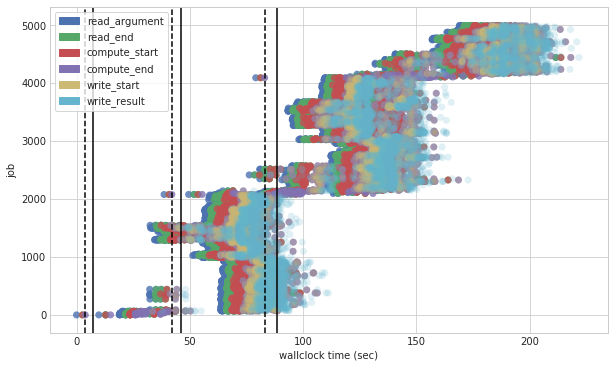

In [24]:
from matplotlib import patches as mpatches
time_offset = np.min([i.start_time for b in profiled_blocks for i in b.instrs if i.start_time != None and i.end_time != None])
instructions = [i for b in profiled_blocks for i in b.instrs if i.start_time != None and i.end_time != None]
fig = pylab.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
total_jobs = len(instructions)
y = np.arange(len(instructions))
point_size = 50

start_times = np.array([i.start_time for i in instructions]) - time_offset
end_times = np.array([i.end_time for i in instructions]) - time_offset
palette = sns.color_palette("deep", 6)
patches = []

READ_INSTRUCTIONS = [lp.OC.S3_LOAD]
WRITE_INSTRUCTIONS = [lp.OC.S3_WRITE]
COMPUTE_INSTRUCTIONS = [lp.OC.SYRK, lp.OC.TRSM, lp.OC.INVRS, lp.OC.CHOL]

read_starts = []
read_ends = []
write_starts = []
write_ends = []
compute_starts = []
compute_ends = []
read_ys = []
write_ys = []
compute_ys = []
write_times = []
compute_times = []
read_times = []
for j,block in enumerate(profiled_blocks):
    syrk = False
    for i in block.instrs:
        if i.start_time == None or i.end_time == None: 
            continue
        if (i.i_code in READ_INSTRUCTIONS):
            read_starts.append(i.start_time - time_offset)
            read_ends.append(i.end_time - time_offset)
            read_times.append(i.end_time - i.start_time)
            read_ys.append(j) 
            
        elif (i.i_code in COMPUTE_INSTRUCTIONS):
            if (i.i_code == lp.OC.SYRK):
                syrk = True
                compute_times.append(i.end_time - i.start_time)
            compute_starts.append(i.start_time - time_offset)
            compute_ends.append(i.end_time - time_offset)
            compute_ys.append(j)
        elif (i.i_code in WRITE_INSTRUCTIONS):
            
            if (syrk):
                write_starts.append(i.start_time - time_offset)
                write_ends.append(i.end_time - time_offset)
                write_times.append(write_ends[-1] - write_starts[-1])
                write_ys.append(j)
       

for i,instr in enumerate(instructions):
    if (instr.i_code == lp.OC.CHOL):
        ax.axvline(instructions[i+1].start_time - time_offset, color="black", linestyle='--')
        ax.axvline(instructions[i+1].end_time - time_offset, color="black")
        
        
        
ax.scatter(read_starts, read_ys,  c=palette[0], edgecolor='none', s=point_size, alpha=0.8)
patches.append(mpatches.Patch(color=palette[0], label="read_argument"))
ax.scatter(read_ends, read_ys,  c=palette[1], edgecolor='none', s=point_size, alpha=0.8)
patches.append(mpatches.Patch(color=palette[1], label="read_end"))

ax.scatter(compute_starts, compute_ys,  c=palette[2], edgecolor='none', s=point_size, alpha=0.8)
patches.append(mpatches.Patch(color=palette[2], label="compute_start"))
ax.scatter(compute_ends, compute_ys,  c=palette[3], edgecolor='none', s=point_size, alpha=0.8)
patches.append(mpatches.Patch(color=palette[3], label="compute_end"))

ax.scatter(write_starts, write_ys,  c=palette[4], edgecolor='none', s=point_size, alpha=0.2)
patches.append(mpatches.Patch(color=palette[4], label="write_start"))
ax.scatter(write_ends, write_ys,  c=palette[5], edgecolor='none', s=point_size, alpha=0.2)
patches.append(mpatches.Patch(color=palette[5], label="write_result"))
ax.set_xlabel('wallclock time (sec)')
ax.set_ylabel('job')

legend = pylab.legend(handles=patches, 
                      loc='upper left', frameon=True)
#pylab.title("Runtime for {} jobs of {:3.0f}M double ops (dgemm) each".format(total_jobs, JOB_GFLOPS))
legend.get_frame().set_facecolor('#FFFFFF')
#ax.set_ylim(2500,2510)
#ax.set_xticks(np.arange(20))
#ax.set_xlim(70,80)

(array([1.710e+02, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.280e+02, 5.778e+03, 5.405e+03, 1.426e+03, 6.940e+02,
        3.170e+02, 1.720e+02, 8.600e+01, 7.900e+01, 3.700e+01, 3.000e+01,
        2.300e+01, 1.200e+01, 1.900e+01, 7.000e+00, 1.400e+01, 5.000e+00,
        3.000e+00, 1.100e+01, 5.000e+00, 6.000e+00, 4.000e+00, 4.000e+00,
        2.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
        3.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 6.000e+00, 1.610e+02, 1.240e+02,
        2.300e+01, 1.500e+01, 6.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

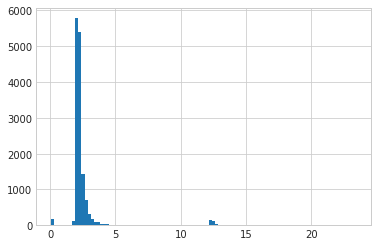

In [25]:
plt.hist(read_times, bins=100)

Text(0,0.5,'Number of jobs completed')

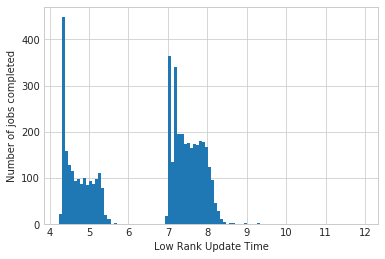

In [26]:
plt.hist(compute_times, bins=100)
plt.xlabel("Low Rank Update Time")
plt.ylabel("Number of jobs completed")

In [27]:
read,write,total_flops,bins, instructions, runtimes = lp.perf_profile(profiled_blocks, num_bins=100)


0 = S3_LOAD BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)) 2 0 0  0.0  2.6187257766723633 2.6187257766723633 gigaflops
RemoteInstructionOpCodes.CHOL
[<RemoteInstructionOpCodes.S3_LOAD: 0>, <RemoteInstructionOpCodes.S3_WRITE: 1>, <RemoteInstructionOpCodes.RET: 6>]
1 = CHOL 0  2.619096517562866  3.8543777465820312 1.235281229019165 gigaflops
2 = S3_WRITE BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)))) 2 0 0 1  3.8546812534332275  7.45201563835144 3.597334384918213 gigaflops
24812 = RET dfea068b9970ae033ee4d58202296e3eb41f28d3  7.452089786529541  7.452895164489746 0.0008053779602050781 gigaflops
4 = S3_LOAD BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)) 2 1 0  9.822243213653564  12.812698602676392 2.990455389022827 gigaflops
5 = S3_LOAD BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_40

947 = S3_LOAD BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)))) 2 17 0  67.03804516792297  69.22591781616211 2.1878726482391357 gigaflops
948 = S3_LOAD BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)))) 2 3 0  69.22606229782104  71.26250386238098 2.0364415645599365 gigaflops
RemoteInstructionOpCodes.SYRK
[<RemoteInstructionOpCodes.S3_LOAD: 0>, <RemoteInstructionOpCodes.S3_WRITE: 1>, <RemoteInstructionOpCodes.RET: 6>]
949 = SYRK 946 947 948  71.26299285888672  79.48040175437927 8.217408895492554 gigaflops
950 = S3_WRITE BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)))_0_trailing) 2 17 3 949  79.48089098930359  84.14610075950623 4.665209770202637 gigaflops
24812 = RET fed24add621689835dc67bf13bd88c83dc742b40  84.14621496200562  84.14661574363708 0.00040078163146972656 gigaflops
951 

1908 = S3_LOAD BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)))) 2 6 0  71.31945157051086  74.3298225402832 3.010370969772339 gigaflops
RemoteInstructionOpCodes.SYRK
[<RemoteInstructionOpCodes.S3_LOAD: 0>, <RemoteInstructionOpCodes.S3_WRITE: 1>, <RemoteInstructionOpCodes.RET: 6>]
1909 = SYRK 1906 1907 1908  74.33021759986877  82.44502830505371 8.114810705184937 gigaflops
1910 = S3_WRITE BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)))_0_trailing) 2 26 6 1909  82.4453866481781  86.80730962753296 4.361922979354858 gigaflops
24812 = RET 8552648604fe9b4a416f2e05124b5200c1fa0129  86.80740523338318  86.80780100822449 0.00039577484130859375 gigaflops
1911 = S3_LOAD BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)) 2 26 7  66.98082494735718  69.71786069869995 2.7370357513427734 gigaflops
1912 = S3_LOAD B

2856 = S3_LOAD BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)) 2 32 25  68.54276752471924  72.47355365753174 3.9307861328125 gigaflops
2857 = S3_LOAD BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)))) 2 32 0  72.47366762161255  74.64271783828735 2.1690502166748047 gigaflops
2858 = S3_LOAD BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)))) 2 25 0  74.64281487464905  76.87173652648926 2.22892165184021 gigaflops
RemoteInstructionOpCodes.SYRK
[<RemoteInstructionOpCodes.S3_LOAD: 0>, <RemoteInstructionOpCodes.S3_WRITE: 1>, <RemoteInstructionOpCodes.RET: 6>]
2859 = SYRK 2856 2857 2858  76.8721091747284  81.68018817901611 4.80807900428772 gigaflops
2860 = S3_WRITE BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)))_0_trailing) 2 32 25 285

3889 = SYRK 3886 3887 3888  72.01688528060913  79.30448937416077 7.287604093551636 gigaflops
3890 = S3_WRITE BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)))_0_trailing) 2 38 24 3889  79.30496263504028  84.66146087646484 5.3564982414245605 gigaflops
24812 = RET 03d03e367eff352bc43b28d12f55b46e3e54ab6d  84.66158032417297  84.66201949119568 0.0004391670227050781 gigaflops
3891 = S3_LOAD BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)) 2 38 25  69.14510416984558  71.75939297676086 2.614288806915283 gigaflops
3892 = S3_LOAD BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)))) 2 38 0  71.75950026512146  73.93232870101929 2.172828435897827 gigaflops
3893 = S3_LOAD BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)))) 2 25 0  73.93241930007

4870 = S3_WRITE BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)))_0_trailing) 2 43 20 4869  82.28437542915344  85.98900628089905 3.7046308517456055 gigaflops
24812 = RET 93a0a2ec4e01e863163a77eb6723813f50d8bbd7  85.98912048339844  85.98951530456543 0.0003948211669921875 gigaflops
4871 = S3_LOAD BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)) 2 43 21  68.54041004180908  71.0845856666565 2.544175624847412 gigaflops
4872 = S3_LOAD BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)))) 2 43 0  71.0846962928772  73.22160243988037 2.136906147003174 gigaflops
4873 = S3_LOAD BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)))) 2 21 0  73.2216956615448  75.47874140739441 2.2570457458496094 gigaflops
RemoteInstructionOpCodes.SYRK
[<RemoteInstru

5931 = S3_LOAD BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)) 2 48 8  58.304208278656006  61.68012475967407 3.3759164810180664 gigaflops
5932 = S3_LOAD BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)))) 2 48 0  61.680253744125366  63.83591032028198 2.155656576156616 gigaflops
5933 = S3_LOAD BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)))) 2 8 0  63.836021184921265  66.22735714912415 2.391335964202881 gigaflops
RemoteInstructionOpCodes.SYRK
[<RemoteInstructionOpCodes.S3_LOAD: 0>, <RemoteInstructionOpCodes.S3_WRITE: 1>, <RemoteInstructionOpCodes.RET: 6>]
5934 = SYRK 5931 5932 5933  66.22776699066162  73.56868886947632 7.340921878814697 gigaflops
5935 = S3_WRITE BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)))_0_trailing) 2 48 

RemoteInstructionOpCodes.SYRK
[<RemoteInstructionOpCodes.S3_LOAD: 0>, <RemoteInstructionOpCodes.S3_WRITE: 1>, <RemoteInstructionOpCodes.RET: 6>]
6904 = SYRK 6901 6902 6903  56.940836906433105  61.29148483276367 4.350647926330566 gigaflops
6905 = S3_WRITE BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)))_0_trailing) 2 52 4 6904  61.29177689552307  66.44251585006714 5.150738954544067 gigaflops
24812 = RET 1121cc1e27106fa33a845f011c92d8b891bb18fb  66.44260430335999  66.44335746765137 0.0007531642913818359 gigaflops
6906 = S3_LOAD BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)) 2 52 5  52.03084135055542  54.67694401741028 2.6461026668548584 gigaflops
6907 = S3_LOAD BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)))) 2 52 0  54.67707848548889  56.862595558166504 2.1855170726776123 gigaflops
6908 = S3_L

[<RemoteInstructionOpCodes.S3_LOAD: 0>, <RemoteInstructionOpCodes.S3_WRITE: 1>, <RemoteInstructionOpCodes.RET: 6>]
7889 = SYRK 7886 7887 7888  64.25079345703125  69.61710047721863 5.366307020187378 gigaflops
7890 = S3_WRITE BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)))_0_trailing) 2 55 42 7889  69.61742544174194  74.40451765060425 4.787092208862305 gigaflops
24812 = RET 1bd6325f0c4bb91aa10a939375fd6640f294d6e7  74.40459489822388  74.40499305725098 0.0003981590270996094 gigaflops
7891 = S3_LOAD BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)) 2 55 43  56.447325706481934  59.14969062805176 2.702364921569824 gigaflops
7892 = S3_LOAD BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)))) 2 55 0  59.149797439575195  61.300331830978394 2.1505343914031982 gigaflops
7893 = S3_LOAD BigMatrix(chol(BigSymmet

8855 = S3_WRITE BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)))_0_trailing) 2 59 9 8854  72.25517630577087  76.42321968078613 4.168043375015259 gigaflops
24812 = RET d71f5fde8bcc42766a6f0caa3128169a06f3c3a3  76.42331314086914  76.42409133911133 0.0007781982421875 gigaflops
8856 = S3_LOAD BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)) 2 59 10  63.284461975097656  65.90535354614258 2.620891571044922 gigaflops
8857 = S3_LOAD BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)))) 2 59 0  65.90546917915344  68.08176875114441 2.176299571990967 gigaflops
8858 = S3_LOAD BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)))) 2 10 0  68.08186721801758  70.25667476654053 2.174807548522949 gigaflops
RemoteInstructionOpCodes.SYRK
[<RemoteInstruct

9823 = S3_LOAD BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)))) 2 23 0  68.11454796791077  70.17923307418823 2.064685106277466 gigaflops
RemoteInstructionOpCodes.SYRK
[<RemoteInstructionOpCodes.S3_LOAD: 0>, <RemoteInstructionOpCodes.S3_WRITE: 1>, <RemoteInstructionOpCodes.RET: 6>]
9824 = SYRK 9821 9822 9823  70.1796395778656  77.44279670715332 7.26315712928772 gigaflops
9825 = S3_WRITE BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)))_0_trailing) 2 62 23 9824  77.44315886497498  81.41928839683533 3.9761295318603516 gigaflops
24812 = RET e106bd992aa9f7b94fa6f93b5b5c8c2ff12f007a  81.41938328742981  81.41973090171814 0.0003476142883300781 gigaflops
9826 = S3_LOAD BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)) 2 62 24  63.63649582862854  66.21585416793823 2.5793583393096924 gigaflops
9827 = S3_LOA

10776 = SYRK 10773 10774 10775  126.47976398468018  134.3980495929718 7.918285608291626 gigaflops
10777 = S3_WRITE BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)))_1_trailing) 2 10 3 10776  134.39840602874756  138.7651448249817 4.366738796234131 gigaflops
24812 = RET 7db4b08f68782151e6a8789ab9adbeff65f8805e  138.76523637771606  138.76609134674072 0.0008549690246582031 gigaflops
10778 = S3_LOAD BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)))_0_trailing) 2 10 4  119.69263195991516  121.9040789604187 2.21144700050354 gigaflops
10779 = S3_LOAD BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)))) 2 10 1  121.90418410301208  124.07281708717346 2.168632984161377 gigaflops
10780 = S3_LOAD BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_2

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



17670 = S3_LOAD BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)))) 2 40 1  112.92993021011353  114.94718027114868 2.0172500610351562 gigaflops
RemoteInstructionOpCodes.SYRK
[<RemoteInstructionOpCodes.S3_LOAD: 0>, <RemoteInstructionOpCodes.S3_WRITE: 1>, <RemoteInstructionOpCodes.RET: 6>]
17671 = SYRK 17668 17669 17670  114.94766974449158  122.29186987876892 7.344200134277344 gigaflops
17672 = S3_WRITE BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)))_1_trailing) 2 54 40 17671  122.29222774505615  126.6834352016449 4.391207456588745 gigaflops
24812 = RET 78d201e3f256cac036c927ca8b4fdb91f3cde254  126.68353056907654  126.68430995941162 0.0007793903350830078 gigaflops
17673 = S3_LOAD BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)))_0_trailing) 2 54 41  110.385005235672  112.698448181152

19419 = S3_LOAD BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)))) 2 60 1  132.307391166687  134.47903442382812 2.1716432571411133 gigaflops
19420 = S3_LOAD BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)))) 2 57 1  134.4791693687439  136.64858508110046 2.1694157123565674 gigaflops
RemoteInstructionOpCodes.SYRK
[<RemoteInstructionOpCodes.S3_LOAD: 0>, <RemoteInstructionOpCodes.S3_WRITE: 1>, <RemoteInstructionOpCodes.RET: 6>]
19421 = SYRK 19418 19419 19420  136.64897108078003  143.8759274482727 7.226956367492676 gigaflops
19422 = S3_WRITE BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)))_1_trailing) 2 60 57 19421  143.87636923789978  149.88230109214783 6.005931854248047 gigaflops
24812 = RET 0ab3f8b5feed4417ace41daaa00bf484caa75012  149.8824098110199  149.88280153274536 0.000391721725

[<RemoteInstructionOpCodes.S3_LOAD: 0>, <RemoteInstructionOpCodes.S3_WRITE: 1>, <RemoteInstructionOpCodes.RET: 6>]
20989 = SYRK 20986 20987 20988  182.71433568000793  187.54792141914368 4.833585739135742 gigaflops
20990 = S3_WRITE BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)))_2_trailing) 2 14 14 20989  187.5482280254364  191.0360128879547 3.4877848625183105 gigaflops
24812 = RET cca5ffacb4d0f3fb246f9b709be0ff393f93f681  191.0360906124115  191.03683614730835 0.0007455348968505859 gigaflops
20991 = S3_LOAD BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)))_1_trailing) 2 15 3  183.9638156890869  186.43975687026978 2.4759411811828613 gigaflops
20992 = S3_LOAD BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)))) 2 15 2  186.43989825248718  188.62239503860474 2.1824967861175537 gigaflops

22638 = S3_LOAD BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)))) 2 4 2  184.1725103855133  186.3528606891632 2.1803503036499023 gigaflops
RemoteInstructionOpCodes.SYRK
[<RemoteInstructionOpCodes.S3_LOAD: 0>, <RemoteInstructionOpCodes.S3_WRITE: 1>, <RemoteInstructionOpCodes.RET: 6>]
22639 = SYRK 22636 22637 22638  186.35337376594543  194.44170999526978 8.08833622932434 gigaflops
22640 = S3_WRITE BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)))_2_trailing) 2 31 4 22639  194.44215607643127  199.6173915863037 5.1752355098724365 gigaflops
24812 = RET fdb102686f2fbb1b131a6821001588ec1478c662  199.61750507354736  199.61792540550232 0.0004203319549560547 gigaflops
22641 = S3_LOAD BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)))_1_trailing) 2 31 5  173.15019869804382  175.33485794067383 

24812 = RET 436cc94862b4b5f4ac576618100b2289224de8c1  192.219740152359  192.22012186050415 0.00038170814514160156 gigaflops
24426 = S3_LOAD BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)))_1_trailing) 2 41 27  168.99437761306763  171.07518005371094 2.0808024406433105 gigaflops
24427 = S3_LOAD BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)))) 2 41 2  171.07530999183655  173.27204203605652 2.1967320442199707 gigaflops
24428 = S3_LOAD BigMatrix(chol(BigSymmetricMatrix(gemm(BigMatrix(cholesky_test_262144_4096), BigMatrix(cholesky_test_262144_4096).T)))) 2 27 2  173.2721552848816  175.3161759376526 2.044020652770996 gigaflops
RemoteInstructionOpCodes.SYRK
[<RemoteInstructionOpCodes.S3_LOAD: 0>, <RemoteInstructionOpCodes.S3_WRITE: 1>, <RemoteInstructionOpCodes.RET: 6>]
24429 = SYRK 24426 24427 24428  175.31667852401733  183.44232606887817 8.1256475448608

In [28]:
optimes = defaultdict(int)
opcounts = defaultdict(int)

In [29]:
for inst, t in zip(instructions, runtimes):
    opcounts[inst.i_code] += 1
    optimes[inst.i_code] += t


In [30]:
for k in optimes.keys():
    print("{0}: {1}s".format(k, optimes[k]/opcounts[k]))
    

RemoteInstructionOpCodes.S3_LOAD: 2.5410260482294245s
RemoteInstructionOpCodes.CHOL: 1.424803892771403s
RemoteInstructionOpCodes.S3_WRITE: 4.726995035171509s
RemoteInstructionOpCodes.RET: 0.0008502787433846238s
RemoteInstructionOpCodes.TRSM: 3.1111646275366507s
RemoteInstructionOpCodes.SYRK: 6.465032080260019s


In [31]:
print(profiled_blocks[32].end_time - profiled_blocks[0].start_time)

32.39603328704834


In [32]:
for k in optimes.keys():
    print("{0}: {1}s".format(k, optimes[k]/opcounts[k]))
    

RemoteInstructionOpCodes.S3_LOAD: 2.5410260482294245s
RemoteInstructionOpCodes.CHOL: 1.424803892771403s
RemoteInstructionOpCodes.S3_WRITE: 4.726995035171509s
RemoteInstructionOpCodes.RET: 0.0008502787433846238s
RemoteInstructionOpCodes.TRSM: 3.1111646275366507s
RemoteInstructionOpCodes.SYRK: 6.465032080260019s


/home/ubuntu/miniconda3/envs/test-environment3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


Text(0,0.5,'aggregate read GB/s')

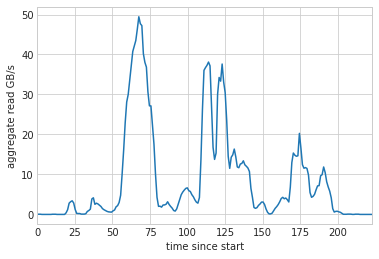

In [33]:
sns.tsplot(read, time=(bins - min(bins)))
plt.xlabel("time since start")
plt.ylabel("aggregate read GB/s")
#plt.xlim(10,12)


/home/ubuntu/miniconda3/envs/test-environment3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


Text(0,0.5,'aggregate write GB/s')

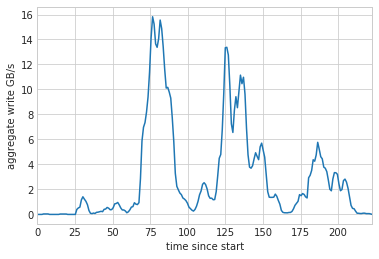

In [34]:
sns.tsplot(write, time=(bins - min(bins)))
plt.xlabel("time since start")
plt.ylabel("aggregate write GB/s")
#plt.xlim(10,12)


In [35]:
pow(3*sum(total_flops), 1.0/3.0)

126.27245311316253

In [36]:
c = sns.palettes.color_palette()[1]

/home/ubuntu/miniconda3/envs/test-environment3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


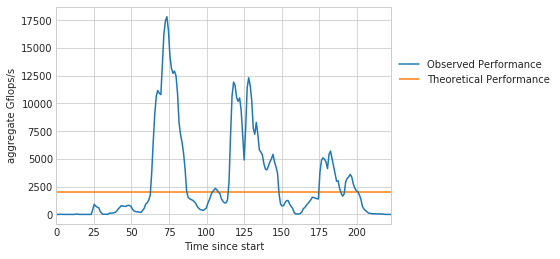

In [37]:
sns.tsplot(total_flops, time=(bins - min(bins)), condition="Observed Performance")
plt.xlabel("Time since start")
plt.ylabel("aggregate Gflops/s")
plt.hlines(20*NUM_CORES,0,1000, label="Theoretical Performance", color=c)
plt.legend(bbox_to_anchor=(1.5, 0.8))
#plt.savefig("flops_100k.pdf")
#plt.xlim(9,10)

In [38]:
((16384**3)/3)/(1e9)

1466.0155037013333

In [41]:
len(all_futures)

3520

In [39]:
# this does not work in current PyWren as it has multiple callsets
# pywren.wait(all_futures)

In [44]:
import concurrent.futures as fs
import redis

all_results = []
bad_counts = 0
bad_counts_1 = 0
bad_counts_2 = 0
bad_counts_3 = 0
bad_future = None
count = 0
for f in all_futures:
    count += 1
    print(count)
    try:
       result = f.result()
       all_results.append(result)
    except fs._base.TimeoutError as e:
        print(e)
        bad_counts += 1
        continue
    except redis.connection.ResponseError as e:
        #print(e)
        bad_counts_1 += 1
        continue
    except Exception as e:
        if str(e) == "process ran out of time":
            bad_counts_2 += 1
        else:
            print(e)
        continue
print("bad counts: " + str(bad_counts))
print("bad counts_1: " + str(bad_counts_1))
print("bad counts_2: " + str(bad_counts_2))
# all_results = [f.result() for f in all_futures]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


2772
2773
2774
2775
2776
2777
2778
2779
2780
2781
2782
2783
2784
2785
2786
2787
2788
2789
2790
2791
2792
2793
2794
2795
2796
2797
2798
2799
2800
2801
2802
2803
2804
2805
2806
2807
2808
2809
2810
2811
2812
2813
2814
2815
2816
2817
2818
2819
2820
2821
2822
2823
2824
2825
2826
2827
2828
2829
2830
2831
2832
2833
2834
2835
2836
2837
2838
2839
2840
2841
2842
2843
2844
2845
2846
2847
2848
2849
2850
2851
2852
2853
2854
2855
2856
2857
2858
2859
2860
2861
2862
2863
2864
2865
2866
2867
2868
2869
2870
2871
2872
2873
2874
2875
2876
2877
2878
2879
2880
2881
2882
2883
2884
2885
2886
2887
2888
2889
2890
2891
2892
2893
2894
2895
2896
2897
2898
2899
2900
2901
2902
2903
2904
2905
2906
2907
2908
2909
2910
2911
2912
2913
2914
2915
2916
2917
2918
2919
2920
2921
2922
2923
2924
2925
2926
2927
2928
2929
2930
2931
2932
2933
2934
2935
2936
2937
2938
2939
2940
2941
2942
2943
2944
2945
2946
2947
2948
2949
2950
2951
2952
2953
2954
2955
2956
2957
2958
2959
2960
2961
2962
2963
2964
2965
2966
2967
2968
2969
2970
2971


In [45]:
len(all_futures)

3520

In [46]:
exec_times = [exec_time for res in all_results for exec_time in res['exec_time']]
up_times = [res['up_time'] for res in all_results]
# print(up_times)

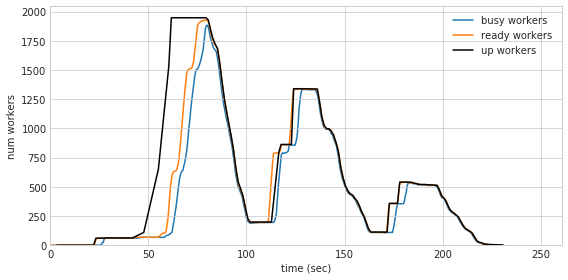

In [47]:
runtime_bins = np.linspace(0, int(max(measure_points) + 1), int(max(measure_points) + 1) * 2)

def compute_times_rates(d, tzero):
    
    x = np.array(d)
    # tzero = np.min(x[:, 0])
    start_time = x[:, 0] - tzero
    end_time = x[:, 1]  - tzero

    N = len(start_time)

    runtime_jobs_hist = np.zeros((N, len(runtime_bins)))

    for i in range(N):
        s = start_time[i]
        e = end_time[i]
        a, b = np.searchsorted(runtime_bins, [s, e])
        if b-a > 0:
            runtime_jobs_hist[i, a:b] = 1

    return {'start_time' : start_time, 
            'end_time' : end_time, 
            'runtime_jobs_hist' : runtime_jobs_hist}

exec_timeline = compute_times_rates(exec_times, tzero)
up_timeline = compute_times_rates(up_times, tzero)

from matplotlib.collections import LineCollection

    
fig = pylab.figure(figsize=(8, 4))

current_palette = sns.color_palette()
up_color = current_palette[0]
exec_color = current_palette[1]

ax = fig.add_subplot(1, 1, 1)

for plot_i, (datum, l, c) in enumerate([(exec_timeline, 'busy workers', up_color), 
                                    (up_timeline, 'ready workers', exec_color)]):

    ax.plot(runtime_bins, datum['runtime_jobs_hist'].sum(axis=0), 
            c=c, label=l, 
           zorder=-1)


    ax.set_xlim(0, np.max(datum['end_time']))
    ax.set_xlabel("time (sec)")

#ax.plot(measure_points, running_total, 'r', label="running tasks")
#ax.plot(measure_points, waiting_total, 'g', label="tasks in queue")
ax.plot(measure_points, up_total, 'black', label="up workers")

ax.set_ylim(0, max(up_total)*1.05)
ax.set_ylabel("num workers")
ax.legend(loc='upper right')
fig.tight_layout()


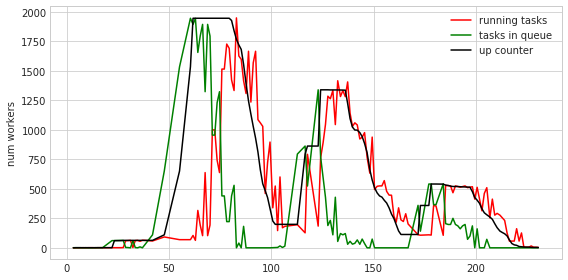

In [48]:
fig = pylab.figure(figsize=(8, 4))

ax = fig.add_subplot(1, 1, 1)
ax.plot(measure_points, running_total, 'r', label="running tasks")
ax.plot(measure_points, waiting_total, 'g', label="tasks in queue")
ax.plot(measure_points, up_total, 'black', label="up counter")
ax.set_ylabel("num workers")
ax.legend(loc='upper right')
fig.tight_layout()


In [49]:
import pickle
results = {"runtime_bins": runtime_bins,
          "exec_timeline": exec_timeline,
          "up_timeline": up_timeline,
          "measure_points": measure_points,
          "running_total": running_total,
          "waiting_total": waiting_total,
          "up_total": waiting_total}
pickle.dump(results, open('cholesky_64k_moderate_10s.pickle', 'wb'))
results = pickle.load(open('cholesky_64k_moderate_10s.pickle', 'rb'))